In [1]:
import numpy as np
import pandas as pd
import glob
import os
from nilearn import plotting
from nilearn import image
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.glm.first_level import make_first_level_design_matrix
import matplotlib.pyplot as plt

all 4 runs (design matrix code from jennifer)

In [42]:
import warnings

from nilearn.image import concat_imgs, mean_img, resample_img

# Avoid getting too many warnings due to resampling
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    four_runs = [
        concat_imgs(os.path.join('func', f'run0{run}', '*.nii'), auto_resample=True) for run in np.arange(4) + 1
    ]
affine, shape = four_runs[0].affine, four_runs[0].shape
print("Resampling the second image (this takes time)...")
four_runs[1] = resample_img(
    four_runs[1], affine, shape[:3],force_resample=True
)

Resampling the second image (this takes time)...


In [43]:
hrf_model = "spm + derivative"
high_pass = 0.01
tr = 2.0  # repetition time is 2000 ms
design_matrices = []
for run in np.arange(4) + 1:
    pattern = os.path.join('func', f'run0{run}', '*.nii')
    nii_files = glob.glob(pattern)
    n_scans = image.load_img(nii_files).shape[-1] #number of scans per acquisition
    frame_times = np.arange(n_scans) * tr  # here are the corresponding frame times
    tsv_file = pd.read_csv(f'func/run0{run}/events.tsv', sep='\t')
    events = tsv_file[['onset', 'duration']]
    design_mat = make_first_level_design_matrix(
        frame_times,
        events,
        hrf_model=hrf_model,
        high_pass=high_pass
    )
    design_matrices.append(design_mat)

/home/jancayan/.local/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
/home/jancayan/.local/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
/home/jancayan/.local/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
/home/jancayan/.local/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(


<Axes: label='conditions', ylabel='scan number'>

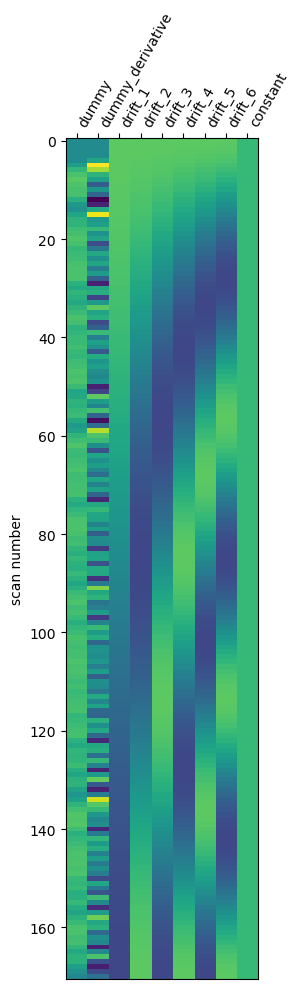

In [39]:
plot_design_matrix(design_mat)

In [16]:
from nilearn.glm.first_level import FirstLevelModel

In [26]:
# contrast_matrix = np.eye(design_mat.shape[1])
# basic_contrasts = {
#     column: contrast_matrix[i]
#     for i, column in enumerate(design_mat.columns)
# }

In [28]:
# basic_contrasts

{'dummy': array([1., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_1': array([0., 1., 0., 0., 0., 0., 0., 0.]),
 'drift_2': array([0., 0., 1., 0., 0., 0., 0., 0.]),
 'drift_3': array([0., 0., 0., 1., 0., 0., 0., 0.]),
 'drift_4': array([0., 0., 0., 0., 1., 0., 0., 0.]),
 'drift_5': array([0., 0., 0., 0., 0., 1., 0., 0.]),
 'drift_6': array([0., 0., 0., 0., 0., 0., 1., 0.]),
 'constant': array([0., 0., 0., 0., 0., 0., 0., 1.])}

In [36]:
# contrasts = {
#     "faces-scrambled": basic_contrasts["faces"] - basic_contrasts["scrambled"],
#     "scrambled-faces": -basic_contrasts["faces"]
#     + basic_contrasts["scrambled"],
#     "effects_of_interest": np.vstack(
#         (basic_contrasts["faces"], basic_contrasts["scrambled"])
#     ),
# }

In [44]:
flm = FirstLevelModel(minimize_memory = False, hrf_model='spm')
flm.fit(four_runs, design_matrices = design_matrices)

FirstLevelModel(hrf_model='spm', minimize_memory=False)

In [45]:
out = image.load_img(flm.predicted)

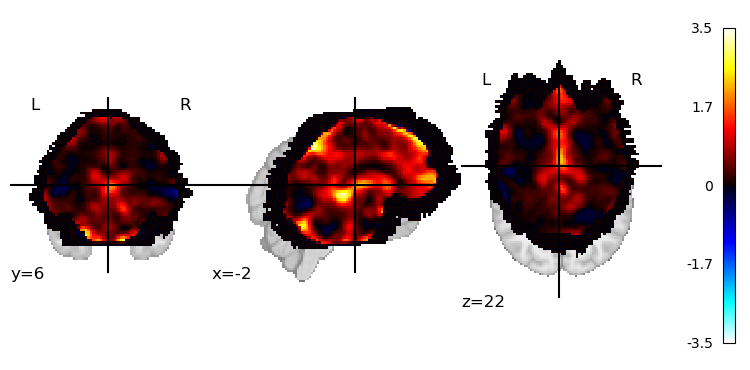

In [46]:
#our results
img = image.index_img(out, 0)
plotting.plot_stat_map(img)

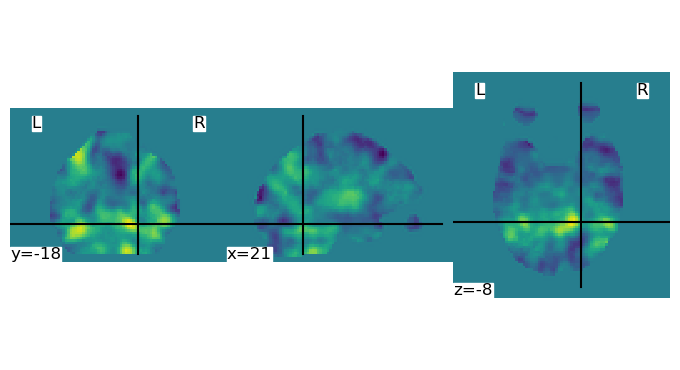

In [23]:
#results from paper 
plotting.plot_img('results/GLM1/spmT_0001.nii')

In [47]:
#flm.fit_transform(img, 'results/GLM1/SPM.mat')